In [6]:
"""
JSONL评估分析工具
直接复制到Jupyter Notebook使用

使用方法:
1. 导入库和函数: 复制本文件所有代码到notebook第一个cell
2. 运行完整分析: analyze_all("your_file.jsonl")
3. 或者单独调用各个函数查看特定统计

示例:
    df, stats, traj = load_and_process("data.jsonl")
    show_basic_stats(df)
    show_trajectory_stats(traj)
    plot_all(df, traj)
"""

import json
import re
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from collections import defaultdict
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('default')
sns.set_palette("husl")

# ==================== 数据提取函数 ====================

def extract_ref_from_text(response: str) -> Optional[int]:
    """从文本中提取ref值，从头扫描第一个数字"""
    match = re.search(r'\d+', response)
    return int(match.group()) if match else None

def extract_score_from_text(response: str) -> Optional[float]:
    """从文本中提取score值，从尾扫描第一个百分号及其前面的数字"""
    matches = list(re.finditer(r'(\d+(?:\.\d+)?)\s*%', response))
    return float(matches[-1].group(1)) if matches else None

def parse_percentage(score_str) -> Optional[float]:
    """解析百分比字符串"""
    if isinstance(score_str, (int, float)):
        return float(score_str)
    if isinstance(score_str, str):
        match = re.search(r'(\d+(?:\.\d+)?)', score_str.strip().replace('%', ''))
        return float(match.group(1)) if match else None
    return None

def check_format(data: Dict) -> bool:
    """检查输出格式是否符合预期"""
    try:
        if 'ref' not in data or 'score' not in data:
            return False
        ref = data['ref']
        if isinstance(ref, str) and not ref.isdigit():
            return False
        elif not isinstance(ref, (int, str)):
            return False
        score = data['score']
        if isinstance(score, str):
            if '%' not in score or not re.search(r'\d+', score):
                return False
        elif not isinstance(score, (int, float)):
            return False
        return True
    except:
        return False

def extract_values(data: Dict) -> Tuple[Optional[int], Optional[float], int]:
    """提取ref和score值，返回: (ref, score, format_score)"""
    format_score = 1 if check_format(data) else 0
    
    # 提取ref
    ref = None
    if 'ref' in data:
        if isinstance(data['ref'], int):
            ref = data['ref']
        elif isinstance(data['ref'], str) and data['ref'].isdigit():
            ref = int(data['ref'])
    if ref is None and 'response' in data:
        ref = extract_ref_from_text(data['response'])
    
    # 提取score
    score = None
    if 'score' in data:
        score = parse_percentage(data['score'])
    if score is None and 'response' in data:
        score = extract_score_from_text(data['response'])
    
    return ref, score, format_score

def compute_relative_error(predicted, ground_truth):
    """计算相对误差: |ground_truth - predicted| / ground_truth"""
    if ground_truth == 0:
        return None
    return abs(ground_truth - predicted) / abs(ground_truth)

def compute_negative_rate(critic_list):
    """计算负值（倒退步骤）的比例"""
    if len(critic_list) == 0:
        return 0.0
    negative_critic = [one for one in critic_list if one < 0]
    return len(negative_critic) / len(critic_list)

# ==================== 数据加载和处理 ====================

def load_and_process(file_path: str):
    """
    加载JSONL文件并处理数据
    
    参数:
        file_path: JSONL文件路径
    
    返回:
        df: 处理后的DataFrame（包含所有样本数据）
        stats_df: 基础统计DataFrame
        traj_df: 轨迹级统计DataFrame
    """
    # 加载数据
    all_data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                all_data.append(json.loads(line))
    
    # 提取所有需要的字段
    processed_data = []
    for data in all_data:
        ref, score, format_score = extract_values(data)
        closest_idx = data.get('closest_idx')
        ground_truth_score = parse_percentage(data.get('ground_truth_score'))
        
        if isinstance(closest_idx, str):
            closest_idx = int(closest_idx) if closest_idx.isdigit() else None
        
        traj_id = data.get('meta_data', {}).get('id', 'unknown')
        
        processed_data.append({
            'trajectory_id': traj_id,
            'ref': ref,
            'score': score,
            'closest_idx': closest_idx,
            'ground_truth_score': ground_truth_score,
            'format_score': format_score
        })
    
    df = pd.DataFrame(processed_data)
    
    # 计算相对误差
    df['ref_error'] = df.apply(
        lambda row: compute_relative_error(row['ref'], row['closest_idx']) 
        if pd.notna(row['ref']) and pd.notna(row['closest_idx']) else None,
        axis=1
    )
    df['score_error'] = df.apply(
        lambda row: compute_relative_error(row['score'], row['ground_truth_score']) 
        if pd.notna(row['score']) and pd.notna(row['ground_truth_score']) else None,
        axis=1
    )
    
    # 计算基础统计
    stats_data = {
        'Metric': [
            'Total Samples',
            'Trajectories',
            'Format Score (%)',
            'Ref Error - Mean',
            'Ref Error - Median',
            'Ref Error - Std',
            'Score Error - Mean',
            'Score Error - Median',
            'Score Error - Std'
        ],
        'Value': [
            len(df),
            df['trajectory_id'].nunique(),
            df['format_score'].mean() * 100,
            df['ref_error'].mean() if df['ref_error'].notna().any() else None,
            df['ref_error'].median() if df['ref_error'].notna().any() else None,
            df['ref_error'].std() if df['ref_error'].notna().any() else None,
            df['score_error'].mean() if df['score_error'].notna().any() else None,
            df['score_error'].median() if df['score_error'].notna().any() else None,
            df['score_error'].std() if df['score_error'].notna().any() else None
        ]
    }
    stats_df = pd.DataFrame(stats_data)
    
    # 计算轨迹级指标
    trajectories = df.groupby('trajectory_id')
    traj_results = []
    
    for traj_id, group in trajectories:
        sorted_group = group.sort_values('ground_truth_score')
        
        # 只使用同时有closest_idx和ref的样本
        valid_samples = sorted_group[
            sorted_group['closest_idx'].notna() & sorted_group['ref'].notna()
        ]
        
        gt_array = valid_samples['closest_idx'].values
        pred_array = valid_samples['ref'].values
        
        # 对于score计算negative rate，使用所有有效的score
        score_array = sorted_group['score'].dropna().values
        
        # Spearman correlation
        spearman_corr = None
        if len(gt_array) >= 2 and len(pred_array) >= 2 and len(gt_array) == len(pred_array):
            corr, _ = spearmanr(gt_array, pred_array)
            spearman_corr = corr if not np.isnan(corr) else None
        
        # Negative Rate
        negative_rate = None
        if len(score_array) >= 2:
            score_diffs = np.diff(score_array)
            negative_rate = compute_negative_rate(score_diffs)
        
        traj_results.append({
            'trajectory_id': traj_id,
            'n_samples': len(group),
            'n_valid_pairs': len(gt_array),  # 新增：有效配对数量
            'spearman_corr': spearman_corr,
            'negative_rate': negative_rate,
            'gt_array': gt_array.tolist(),
            'pred_array': pred_array.tolist()
        })
    
    traj_df = pd.DataFrame(traj_results)
    
    print(f"✅ 成功加载 {len(df)} 条数据，{df['trajectory_id'].nunique()} 个轨迹")
    
    return df, stats_df, traj_df

# ==================== 统计展示函数 ====================

def show_basic_stats(df: pd.DataFrame):
    """显示基础统计信息"""
    print("=" * 80)
    print("📊 基础统计")
    print("=" * 80)
    
    print(f"\n总样本数: {len(df)}")
    print(f"轨迹数量: {df['trajectory_id'].nunique()}")
    print(f"格式正确率: {df['format_score'].mean():.2%} ({df['format_score'].sum()}/{len(df)})")
    
    print("\n【Ref vs Closest_idx 相对误差】")
    ref_error = df['ref_error'].dropna()
    if len(ref_error) > 0:
        print(f"  均值:   {ref_error.mean():.4f}")
        print(f"  中位数: {ref_error.median():.4f}")
        print(f"  标准差: {ref_error.std():.4f}")
        print(f"  有效样本: {len(ref_error)}/{len(df)}")
    else:
        print("  无有效数据")
    
    print("\n【Score vs Ground_truth_score 相对误差】")
    score_error = df['score_error'].dropna()
    if len(score_error) > 0:
        print(f"  均值:   {score_error.mean():.4f}")
        print(f"  中位数: {score_error.median():.4f}")
        print(f"  标准差: {score_error.std():.4f}")
        print(f"  有效样本: {len(score_error)}/{len(df)}")
    else:
        print("  无有效数据")
    
    print("\n" + "=" * 80)

def show_trajectory_stats(traj_df: pd.DataFrame):
    """显示轨迹级统计信息"""
    print("=" * 80)
    print("📈 轨迹级统计")
    print("=" * 80)
    
    print(f"\n总轨迹数: {len(traj_df)}")
    
    # 显示样本数和有效配对数统计
    if 'n_valid_pairs' in traj_df.columns:
        total_samples = traj_df['n_samples'].sum()
        total_valid_pairs = traj_df['n_valid_pairs'].sum()
        print(f"总样本数: {total_samples}")
        print(f"有效配对数: {total_valid_pairs} ({total_valid_pairs/total_samples*100:.1f}%)")
    
    print("\n【Spearman Correlation】")
    spearman = traj_df['spearman_corr'].dropna()
    if len(spearman) > 0:
        print(f"  均值:   {spearman.mean():.4f}")
        print(f"  中位数: {spearman.median():.4f}")
        print(f"  标准差: {spearman.std():.4f}")
        print(f"  最小值: {spearman.min():.4f}")
        print(f"  最大值: {spearman.max():.4f}")
        print(f"  有效轨迹: {len(spearman)}/{len(traj_df)}")
    else:
        print("  无有效数据")
    
    print("\n【Negative Rate】")
    negative = traj_df['negative_rate'].dropna()
    if len(negative) > 0:
        print(f"  均值:   {negative.mean():.4f}")
        print(f"  中位数: {negative.median():.4f}")
        print(f"  标准差: {negative.std():.4f}")
        print(f"  最小值: {negative.min():.4f}")
        print(f"  最大值: {negative.max():.4f}")
        print(f"  有效轨迹: {len(negative)}/{len(traj_df)}")
    else:
        print("  无有效数据")
    
    print("\n" + "=" * 80)

def show_summary(df: pd.DataFrame, traj_df: pd.DataFrame):
    """显示汇总信息"""
    print("=" * 80)
    print("📋 汇总报告")
    print("=" * 80)
    
    summary = {
        'Format Score': f"{df['format_score'].mean():.2%}",
        'Ref Error (Mean)': f"{df['ref_error'].mean():.4f}" if df['ref_error'].notna().any() else "N/A",
        'Score Error (Mean)': f"{df['score_error'].mean():.4f}" if df['score_error'].notna().any() else "N/A",
        'Spearman Corr (Mean)': f"{traj_df['spearman_corr'].mean():.4f}" if traj_df['spearman_corr'].notna().any() else "N/A",
        'Negative Rate (Mean)': f"{traj_df['negative_rate'].mean():.4f}" if traj_df['negative_rate'].notna().any() else "N/A"
    }
    
    for key, value in summary.items():
        print(f"{key:25s}: {value}")
    
    print("=" * 80)

# ==================== 可视化函数 ====================

def plot_error_dist(df: pd.DataFrame):
    """绘制误差分布图"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Ref Error
    ref_errors = df['ref_error'].dropna()
    if len(ref_errors) > 0:
        n_bins = min(30, max(5, len(ref_errors) // 2))  # 自适应bins数量
        axes[0].hist(ref_errors, bins=n_bins, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0].axvline(ref_errors.mean(), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {ref_errors.mean():.4f}')
        axes[0].axvline(ref_errors.median(), color='green', linestyle='--', linewidth=2,
                       label=f'Median: {ref_errors.median():.4f}')
        axes[0].set_xlabel('Relative Error', fontsize=12)
        axes[0].set_ylabel('Frequency', fontsize=12)
        axes[0].set_title('Ref vs Closest_idx - Relative Error', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)
    
    # Score Error
    score_errors = df['score_error'].dropna()
    if len(score_errors) > 0:
        n_bins = min(30, max(5, len(score_errors) // 2))  # 自适应bins数量
        axes[1].hist(score_errors, bins=n_bins, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1].axvline(score_errors.mean(), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {score_errors.mean():.4f}')
        axes[1].axvline(score_errors.median(), color='green', linestyle='--', linewidth=2,
                       label=f'Median: {score_errors.median():.4f}')
        axes[1].set_xlabel('Relative Error', fontsize=12)
        axes[1].set_ylabel('Frequency', fontsize=12)
        axes[1].set_title('Score vs Ground_truth - Relative Error', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_trajectory_metrics(traj_df: pd.DataFrame):
    """绘制轨迹级指标分布"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Spearman Correlation
    spearman = traj_df['spearman_corr'].dropna()
    if len(spearman) > 0:
        n_bins = min(20, max(5, len(spearman) // 2))  # 自适应bins数量
        axes[0].hist(spearman, bins=n_bins, alpha=0.7, color='mediumseagreen', edgecolor='black')
        axes[0].axvline(spearman.mean(), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {spearman.mean():.4f}')
        axes[0].set_xlabel('Spearman Correlation', fontsize=12)
        axes[0].set_ylabel('Frequency', fontsize=12)
        axes[0].set_title('Spearman Correlation Distribution', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)
    
    # Negative Rate
    negative = traj_df['negative_rate'].dropna()
    if len(negative) > 0:
        n_bins = min(20, max(5, len(negative) // 2))  # 自适应bins数量
        axes[1].hist(negative, bins=n_bins, alpha=0.7, color='mediumpurple', edgecolor='black')
        axes[1].axvline(negative.mean(), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {negative.mean():.4f}')
        axes[1].set_xlabel('Negative Rate', fontsize=12)
        axes[1].set_ylabel('Frequency', fontsize=12)
        axes[1].set_title('Negative Rate Distribution', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_trajectory_comparison(traj_df: pd.DataFrame, n_samples: int = 5):
    """绘制GT vs Pred对比图"""
    sample_trajs = traj_df.head(n_samples)
    n_plots = len(sample_trajs)
    
    if n_plots == 0:
        print("⚠️ 没有可绘制的轨迹")
        return
    
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 4 * n_plots))
    if n_plots == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(sample_trajs.iterrows()):
        ax = axes[idx]
        gt_array = row['gt_array']
        pred_array = row['pred_array']
        
        # 确保两个数组长度一致
        if len(gt_array) > 0 and len(pred_array) > 0:
            min_len = min(len(gt_array), len(pred_array))
            if min_len > 0:
                gt_array_plot = gt_array[:min_len]
                pred_array_plot = pred_array[:min_len]
                
                x = range(min_len)
                ax.plot(x, gt_array_plot, marker='o', label='Ground Truth', 
                       linewidth=2, markersize=8, color='#2E86AB')
                ax.plot(x, pred_array_plot, marker='s', label='Prediction', 
                       linewidth=2, markersize=8, color='#A23B72')
                
                corr_text = f"Spearman: {row['spearman_corr']:.4f}" if pd.notna(row['spearman_corr']) else "Spearman: N/A"
                
                # 如果长度不同，添加警告
                if len(gt_array) != len(pred_array):
                    corr_text += f" | ⚠️ GT:{len(gt_array)}, Pred:{len(pred_array)}"
                
                ax.set_xlabel('Sample Index (sorted by ground_truth_score)', fontsize=11)
                ax.set_ylabel('Frame Index', fontsize=11)
                ax.set_title(f"Trajectory {idx+1}: {row['trajectory_id'][:60]}... | {corr_text}", 
                            fontsize=12, fontweight='bold')
                ax.legend(fontsize=10)
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=12)
                ax.set_title(f"Trajectory {idx+1}: {row['trajectory_id'][:60]}...", 
                            fontsize=12, fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=12)
            ax.set_title(f"Trajectory {idx+1}: {row['trajectory_id'][:60]}...", 
                        fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_all(df: pd.DataFrame, traj_df: pd.DataFrame):
    """绘制所有可视化图表"""
    print("📊 生成可视化图表...\n")
    plot_error_dist(df)
    plot_trajectory_metrics(traj_df)
    plot_trajectory_comparison(traj_df, n_samples=5)
    print("✅ 可视化完成!")

# ==================== 一键分析函数 ====================

def analyze_all(file_path: str):
    """
    一键运行完整分析
    
    参数:
        file_path: JSONL文件路径
    
    返回:
        df: 样本级DataFrame
        stats_df: 基础统计DataFrame
        traj_df: 轨迹级DataFrame
    """
    print("🚀 开始完整分析...\n")
    
    # 加载和处理数据
    df, stats_df, traj_df = load_and_process(file_path)
    print()
    
    # 显示统计信息
    show_basic_stats(df)
    print()
    show_trajectory_stats(traj_df)
    print()
    show_summary(df, traj_df)
    print()
    
    # 可视化
    plot_all(df, traj_df)
    
    # print("\n✅ 分析完成!")
    # print(f"\n💾 数据已保存在变量中:")
    # print(f"   - df: 样本级数据 ({len(df)} 条)")
    # print(f"   - stats_df: 基础统计数据")
    # print(f"   - traj_df: 轨迹级数据 ({len(traj_df)} 条)")
    
    return df, stats_df, traj_df

# ==================== 使用说明 ====================

def print_usage():
    """打印使用说明"""
    print("=" * 80)
    print("📖 使用说明")
    print("=" * 80)
    print("""
1. 一键分析（推荐）:
   df, stats, traj = analyze_all("your_file.jsonl")

2. 分步分析:
   # 加载数据
   df, stats, traj = load_and_process("your_file.jsonl")
   
   # 查看统计
   show_basic_stats(df)
   show_trajectory_stats(traj)
   show_summary(df, traj)
   
   # 可视化
   plot_error_dist(df)
   plot_trajectory_metrics(traj)
   plot_trajectory_comparison(traj, n_samples=5)
   plot_all(df, traj)

3. 数据导出:
   df.to_csv('samples.csv', index=False)
   stats.to_csv('stats.csv', index=False)
   traj.to_csv('trajectories.csv', index=False)

4. 自定义分析:
   # 查看格式错误的样本
   format_errors = df[df['format_score'] == 0]
   
   # 查看最佳轨迹
   best = traj.nlargest(5, 'spearman_corr')
   
   # 查看特定轨迹
   traj_id = "your_trajectory_id"
   specific_traj = df[df['trajectory_id'] == traj_id]
    """)
    print("=" * 80)

print("✅ 评估工具加载完成!")
print("💡 输入 print_usage() 查看使用说明")

✅ 评估工具加载完成!
💡 输入 print_usage() 查看使用说明


## Qwen2.5VL-3B-SFT

🚀 开始完整分析...

✅ 成功加载 2991 条数据，226 个轨迹

📊 基础统计

总样本数: 2991
轨迹数量: 226
格式正确率: 100.00% (2991/2991)

【Ref vs Closest_idx 相对误差】
  均值:   0.3230
  中位数: 0.2500
  标准差: 0.5279
  有效样本: 2991/2991

【Score vs Ground_truth_score 相对误差】
  均值:   0.6380
  中位数: 0.3231
  标准差: 1.5092
  有效样本: 2991/2991


📈 轨迹级统计

总轨迹数: 226
总样本数: 2991
有效配对数: 2991 (100.0%)

【Spearman Correlation】
  均值:   0.5173
  中位数: 0.6017
  标准差: 0.3312
  最小值: -0.6200
  最大值: 0.9464
  有效轨迹: 225/226

【Negative Rate】
  均值:   0.4061
  中位数: 0.4286
  标准差: 0.1056
  最小值: 0.0000
  最大值: 0.6364
  有效轨迹: 226/226


📋 汇总报告
Format Score             : 100.00%
Ref Error (Mean)         : 0.3230
Score Error (Mean)       : 0.6380
Spearman Corr (Mean)     : 0.5173
Negative Rate (Mean)     : 0.4061

📊 生成可视化图表...



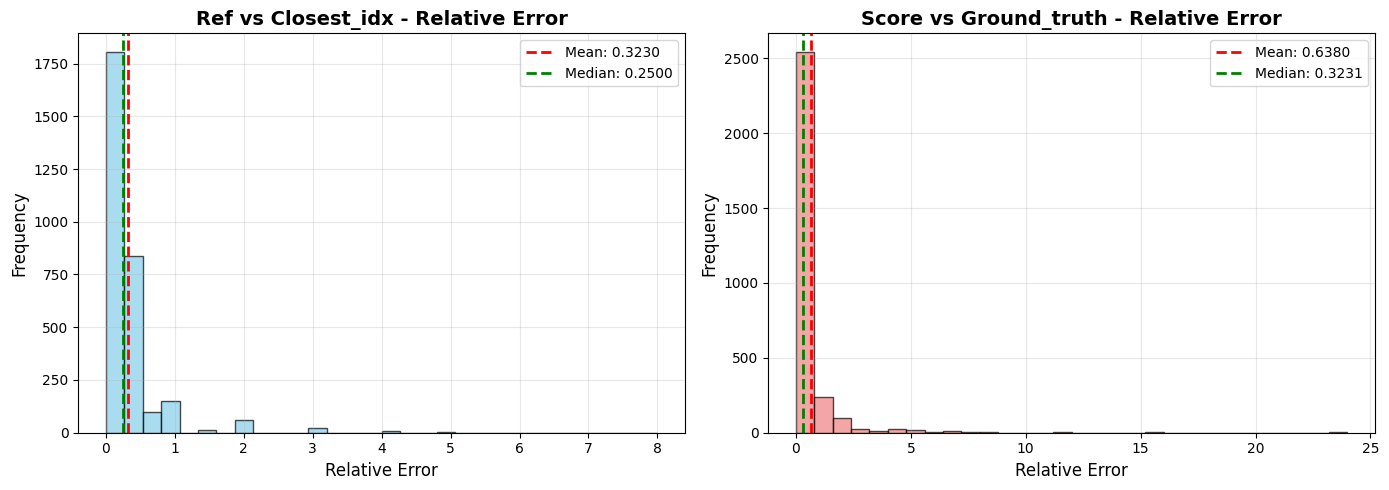

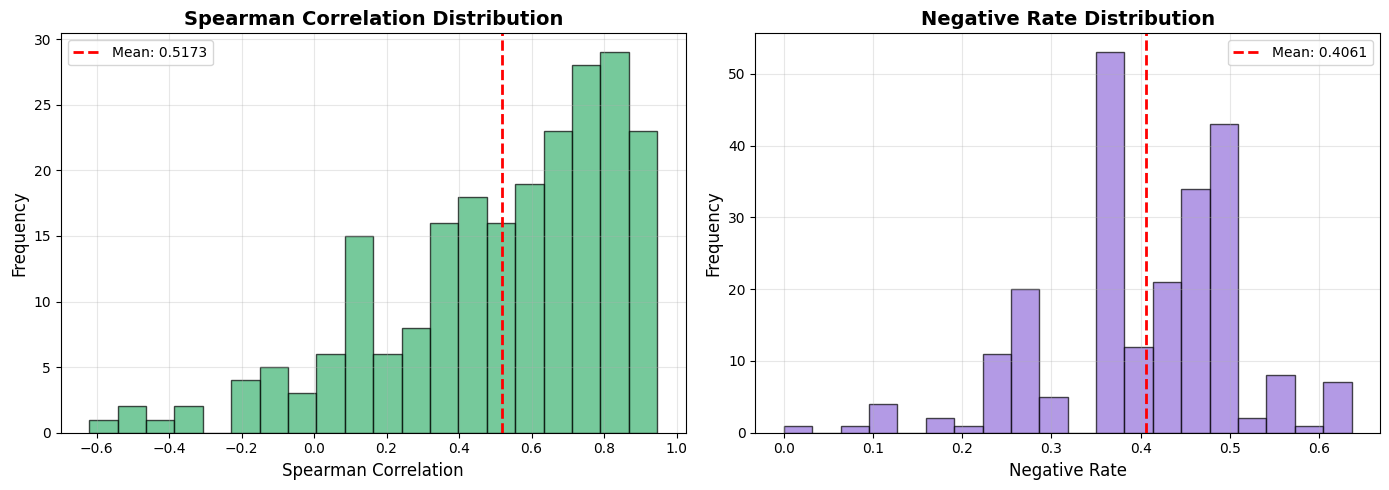

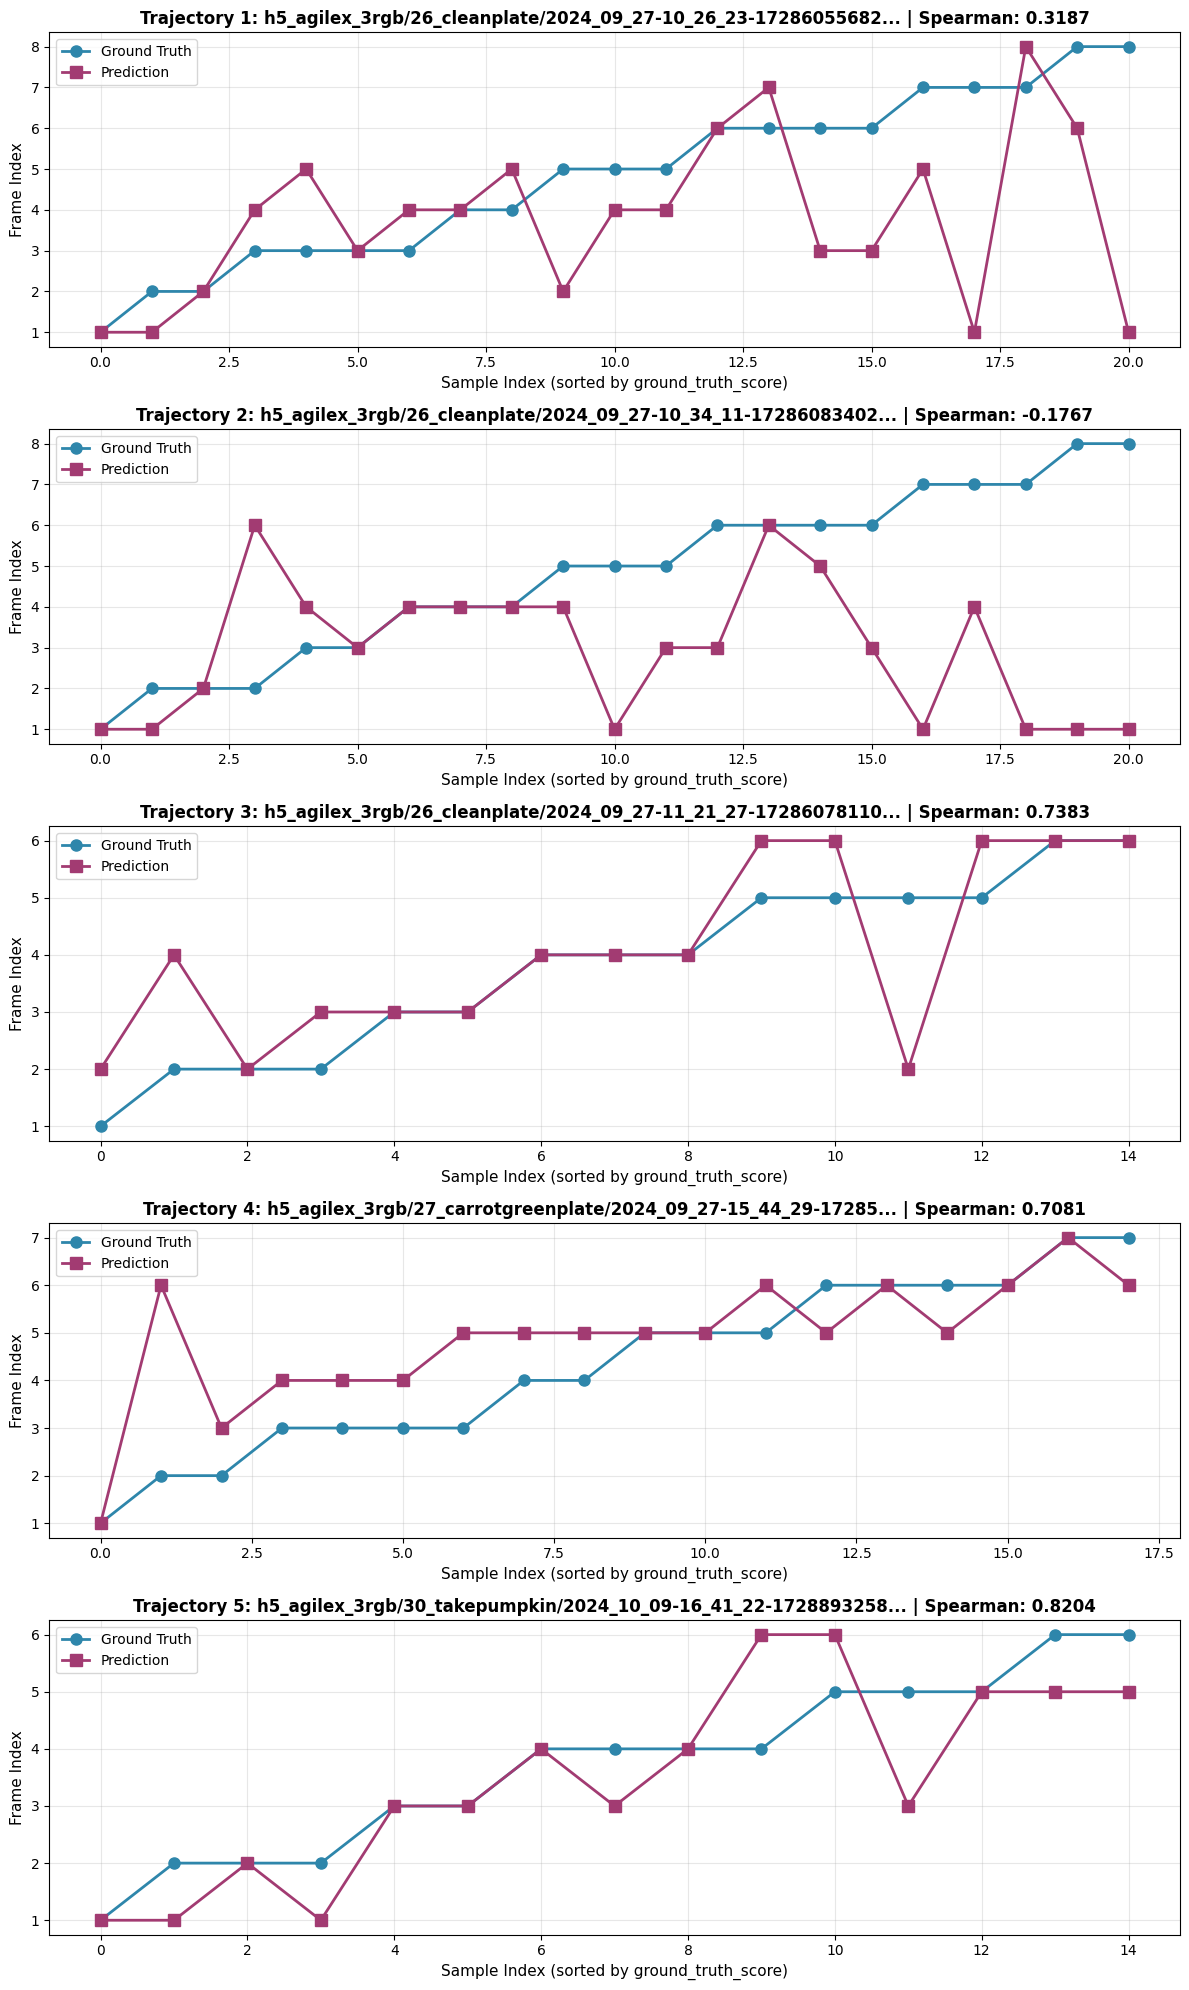

✅ 可视化完成!


In [7]:
df, stats, traj = analyze_all("/projects/b1222/userdata/jianshu/chengxuan/saved/eval_results/sft_3b_visual/clean/eval_sft3b_visual_20251030_231344.jsonl")

## Qwen2.5VL-3B-RL

🚀 开始完整分析...

✅ 成功加载 2991 条数据，226 个轨迹

📊 基础统计

总样本数: 2991
轨迹数量: 226
格式正确率: 100.00% (2991/2991)

【Ref vs Closest_idx 相对误差】
  均值:   0.1957
  中位数: 0.0000
  标准差: 0.4363
  有效样本: 2991/2991

【Score vs Ground_truth_score 相对误差】
  均值:   0.2901
  中位数: 0.1458
  标准差: 0.8163
  有效样本: 2991/2991


📈 轨迹级统计

总轨迹数: 226
总样本数: 2991
有效配对数: 2991 (100.0%)

【Spearman Correlation】
  均值:   0.8758
  中位数: 0.9164
  标准差: 0.1172
  最小值: 0.1708
  最大值: 0.9888
  有效轨迹: 226/226

【Negative Rate】
  均值:   0.1281
  中位数: 0.1250
  标准差: 0.1081
  最小值: 0.0000
  最大值: 0.4286
  有效轨迹: 226/226


📋 汇总报告
Format Score             : 100.00%
Ref Error (Mean)         : 0.1957
Score Error (Mean)       : 0.2901
Spearman Corr (Mean)     : 0.8758
Negative Rate (Mean)     : 0.1281

📊 生成可视化图表...



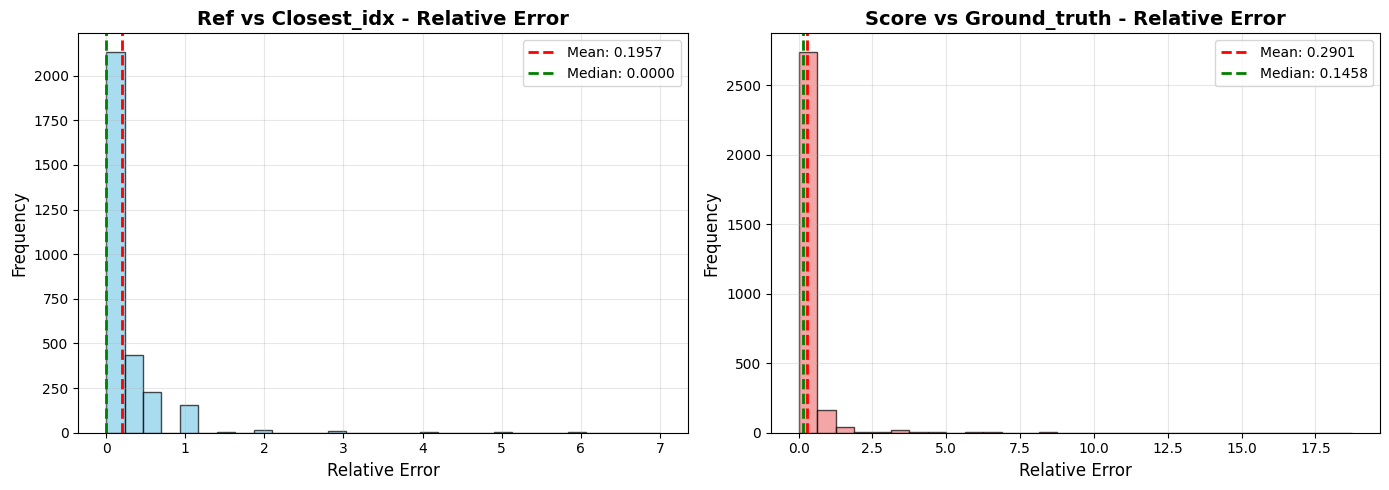

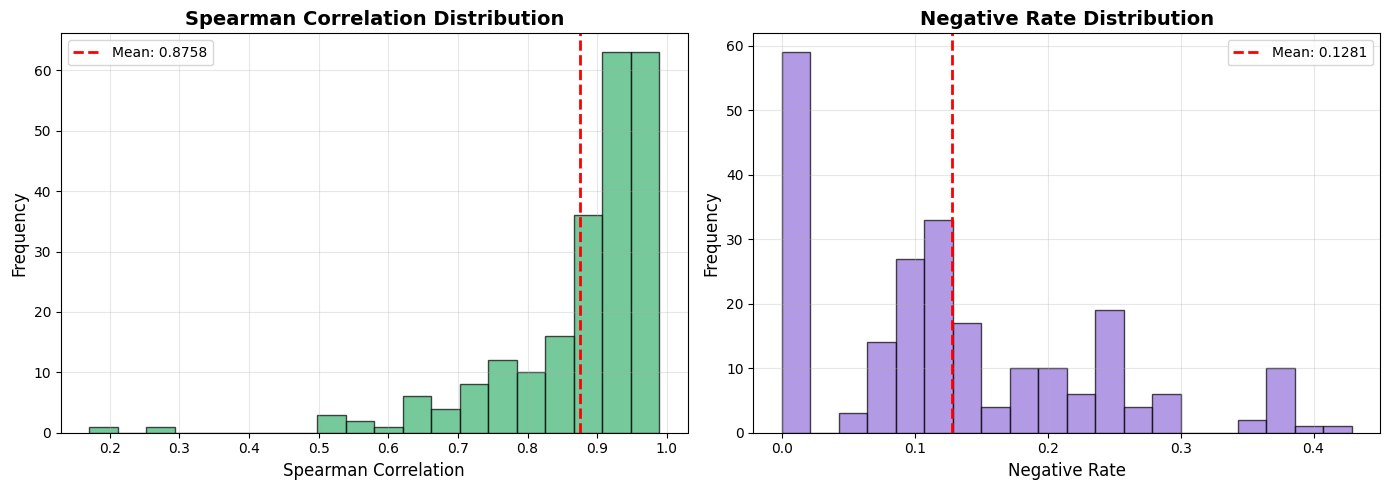

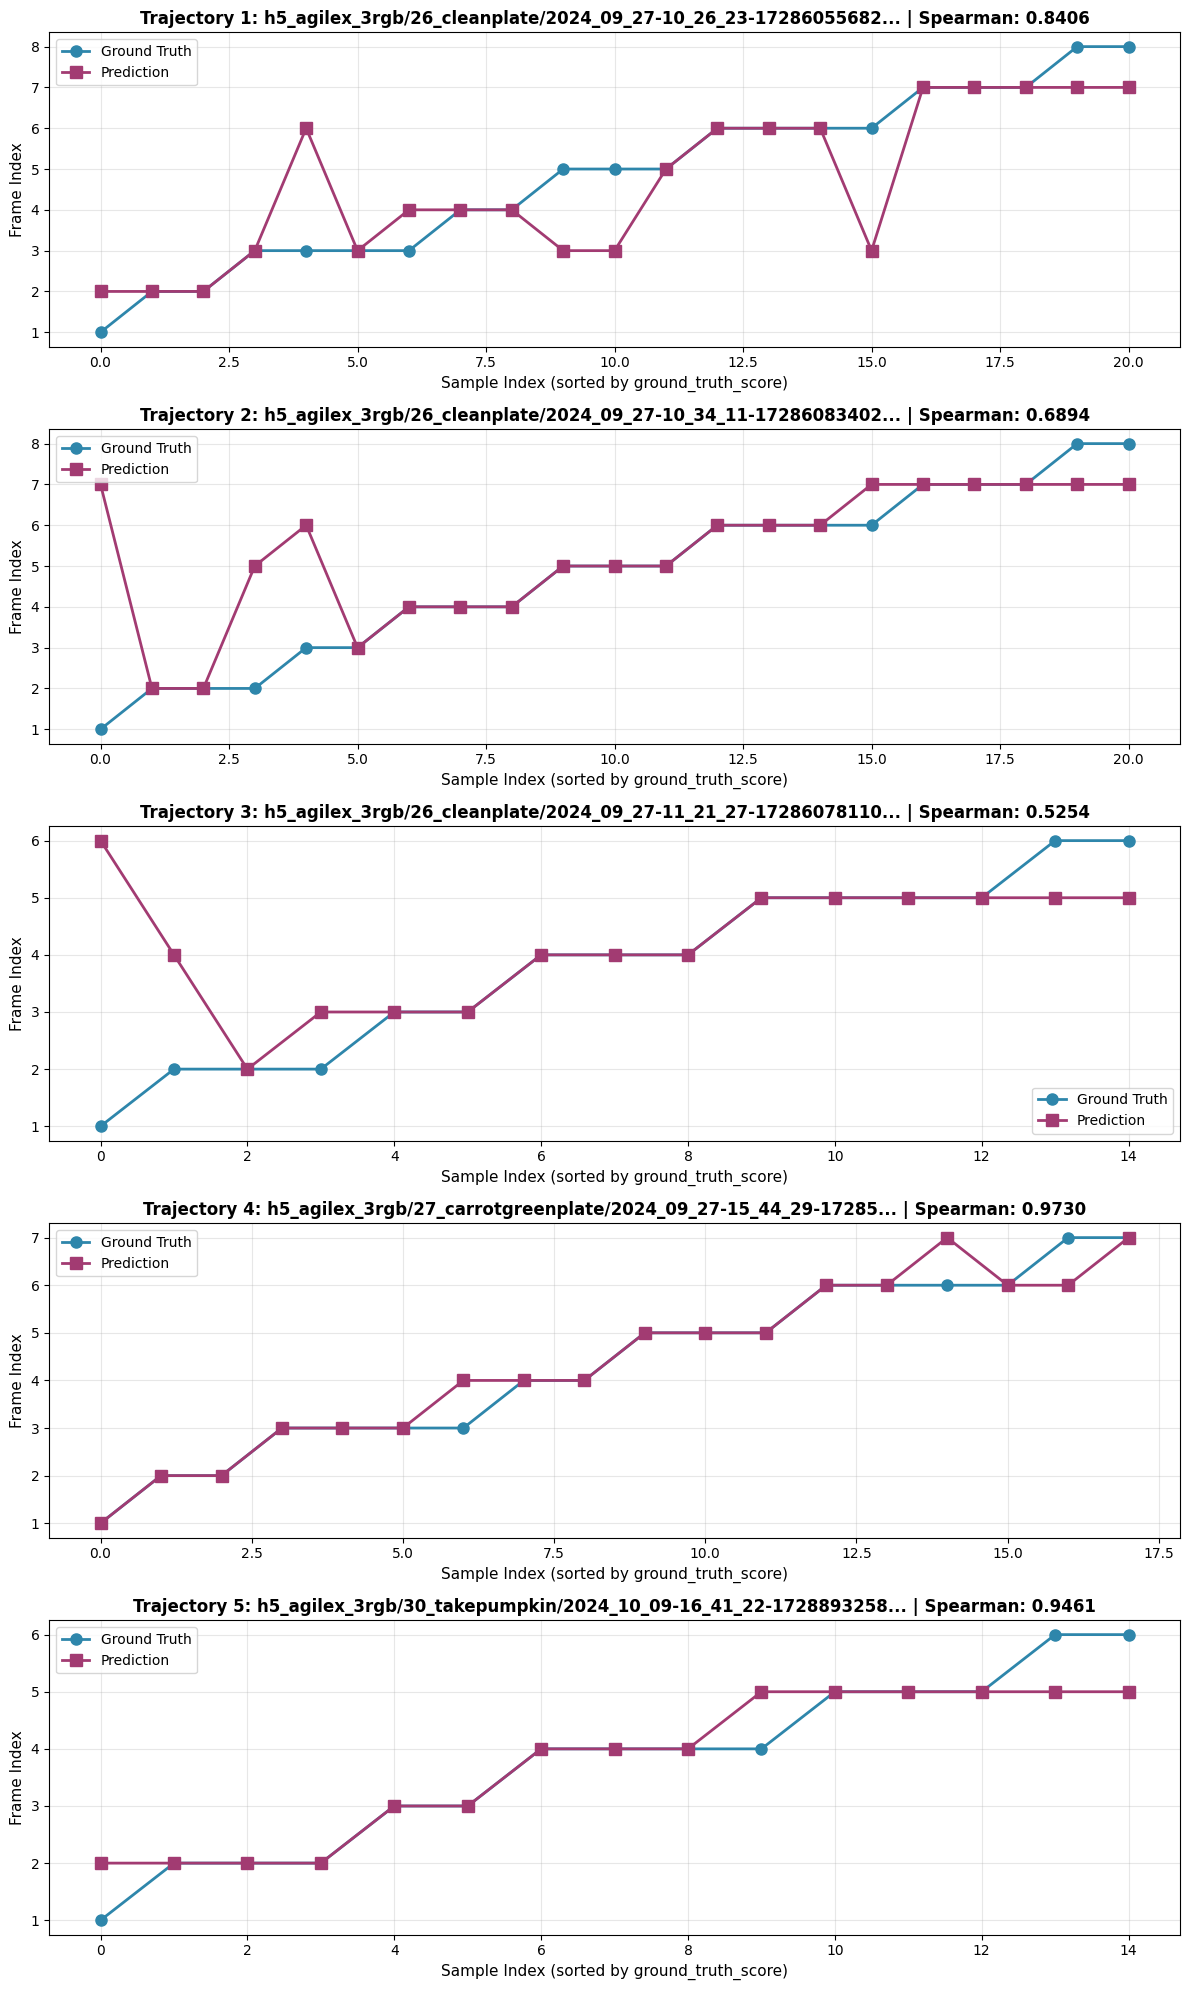

✅ 可视化完成!


In [8]:
df, stats, traj = analyze_all("/projects/b1222/userdata/jianshu/chengxuan/saved/eval_results/rl_visual/eval_sft3b_visual_20251030_213044.jsonl")

🚀 开始完整分析...



✅ 成功加载 3432 条数据，212 个轨迹

📊 基础统计

总样本数: 3432
轨迹数量: 212
格式正确率: 99.97% (3431/3432)

【Ref vs Closest_idx 相对误差】
  均值:   0.3388
  中位数: 0.2500
  标准差: 0.5288
  有效样本: 3432/3432

【Score vs Ground_truth_score 相对误差】
  均值:   0.6434
  中位数: 0.3151
  标准差: 1.7940
  有效样本: 3431/3432


📈 轨迹级统计

总轨迹数: 212
总样本数: 3432
有效配对数: 3432 (100.0%)

【Spearman Correlation】
  均值:   0.5195
  中位数: 0.6303
  标准差: 0.3220
  最小值: -0.6081
  最大值: 0.9475
  有效轨迹: 209/212

【Negative Rate】
  均值:   0.4180
  中位数: 0.4231
  标准差: 0.0993
  最小值: 0.1250
  最大值: 0.7000
  有效轨迹: 212/212


📋 汇总报告
Format Score             : 99.97%
Ref Error (Mean)         : 0.3388
Score Error (Mean)       : 0.6434
Spearman Corr (Mean)     : 0.5195
Negative Rate (Mean)     : 0.4180

📊 生成可视化图表...



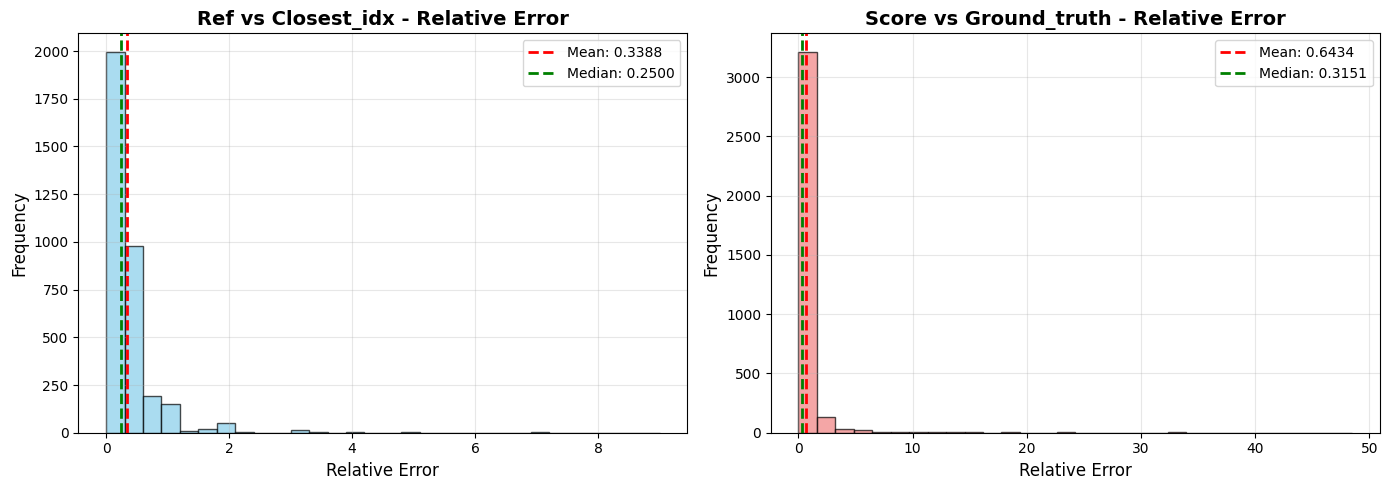

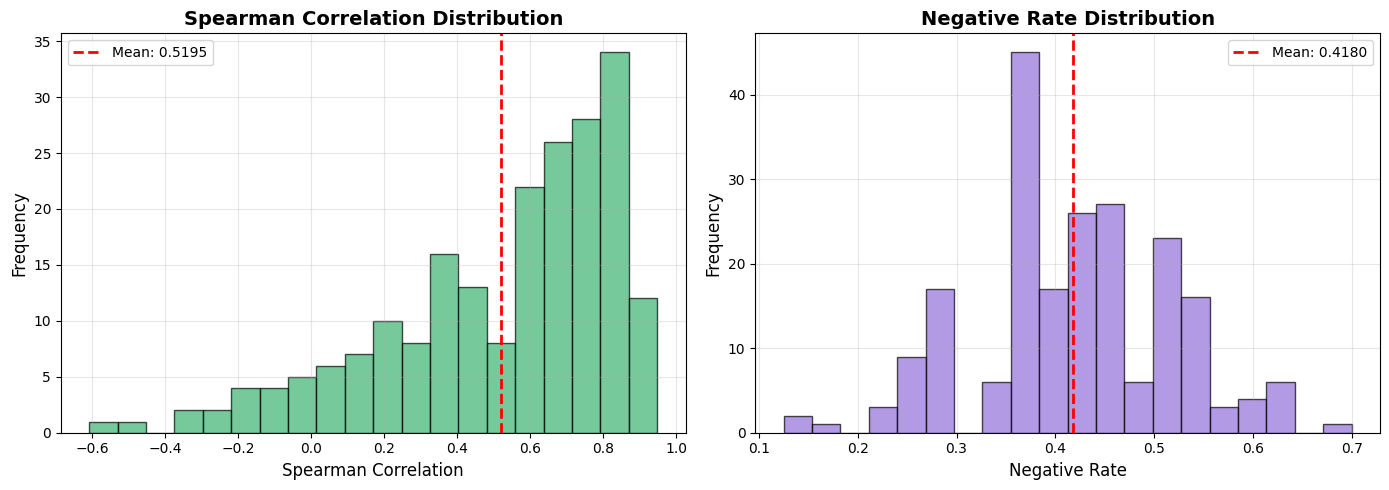

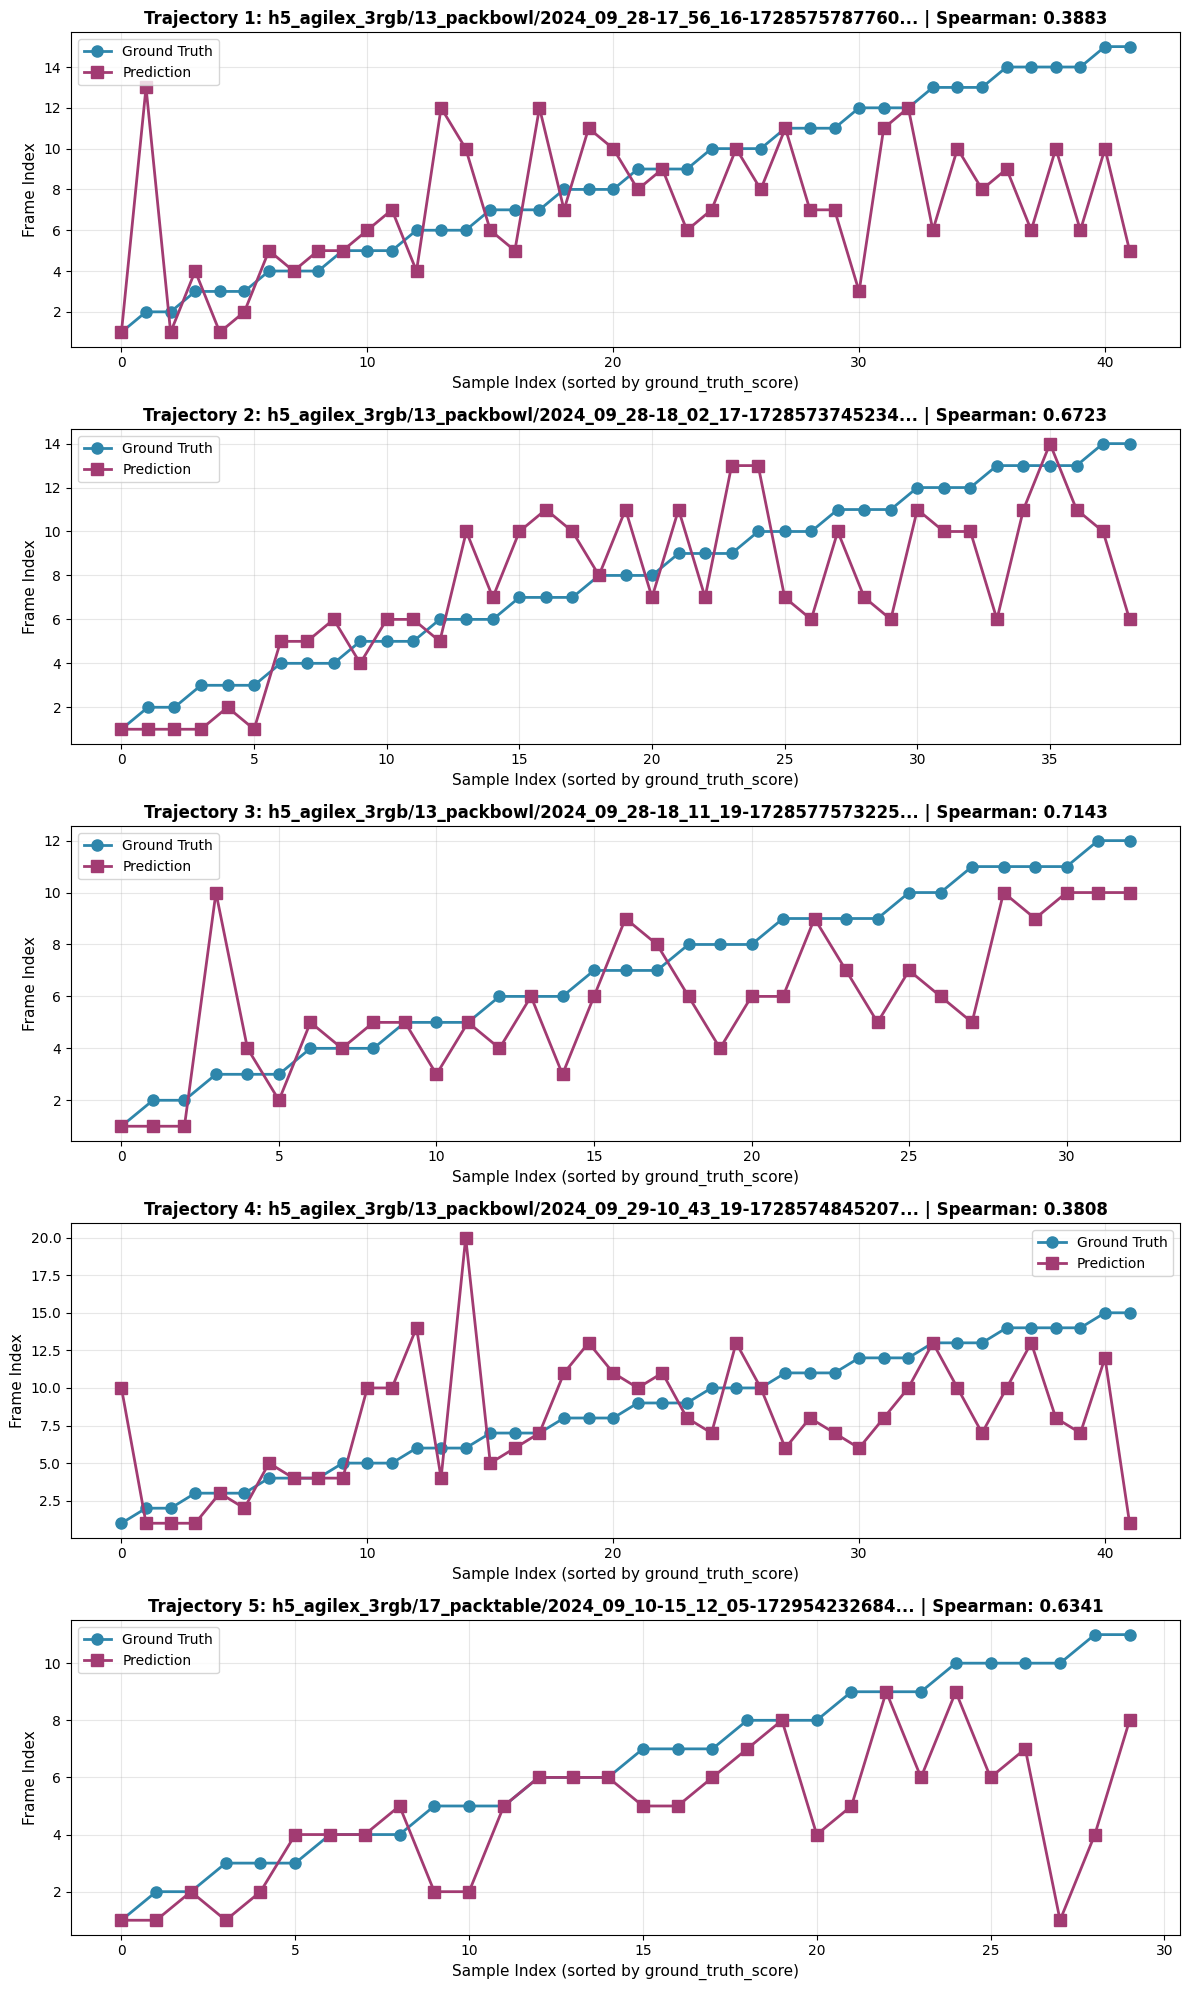

✅ 可视化完成!


In [9]:
# SFT 3b 
df, stats, traj = analyze_all("/projects/b1222/userdata/jianshu/chengxuan/saved/eval_results/sft_3b_visual/tiny/sft/eval_sft3b_visual_20251023_163702.jsonl")

In [ ]:
# 7b sft
df, stats, traj = analyze_all("/projects/b1222/userdata/jianshu/chengxuan/saved/eval_new_results/7b_sft_visual_new/eval_sft7b_visual_20251031_125423.jsonl")